In [1]:
# Import the nescessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# For plotting
import matplotlib.pyplot as plt

# Dataset download

We will be using the MNIST dataset for our studies. This dataset is widely recognized and frequently serves as a benchmark for many deep learning models, making it readily accessible through the PyTorch datasets class.

To load the datasets and prepare them for training, we will utilize PyTorch's built-in datasets and DataLoader classes.

The datasets.MNIST class retrieves the data from the internet and applies certain transformations to it. These transformations are specified in the transform object, which includes transforms.ToTensor(), converting our data into PyTorch tensors, and transforms.Normalize((0.5,), (0.5,)), normalizing our data (gray pixel values) so that the mean is 0 and the standard deviation is 1, using the formula (x-0.5)/0.5.

The DataLoader is responsible for shuffling and dividing our training and test data into batches, according to the batch_size parameter. It can also parallelize the process with the num_workers parameter, which specifies how many subprocesses to use for data loading. This provides an efficient and straightforward method to prepare your data for training.

The train_loader yields two objects, data and targets (data, targets = train_loader). The targets contain the true labels for our training data.

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

batch_size = 32
trainset = datasets.MNIST(root='./data/', train=True, download=False, transform=transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=5)

testset = datasets.MNIST(root='./data/', train=False, download=False, transform=transform)
test_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=5)

## Plotting

To get a felling of the dataset, lets plot some of the downloaded images

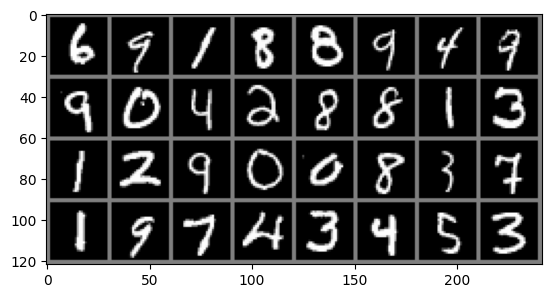

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

## Convolutional neural networks

Now that we have fetched our dataset and divided it into training and test sets, we can define our model for the training process.

The task is to train a Convolutional Neural Network (CNN) to classify the images into their respective digits. For instance, if we input an image of the number 9, we want the model to classify it as a 9.

As covered in the lectures, CNNs are well-suited for this type of task. We will employ PyTorch's built-in 2D convolutions to construct our model.

Our model utilizes two-dimensional convolutional layers (nn.Conv2d), 2D max pooling (max_pool2d), linear layers (nn.Linear), and ReLU activation layers (F.relu).

`max_pool2d`: This operation applies 2D max pooling over an input signal composed of several input planes, effectively reducing its dimensionality for computational efficiency and to help in achieving translational invariance.

`nn.Conv2d`: This layer applies a 2D convolution over an input signal composed of several input planes. It's fundamental in detecting patterns and features within the images.

`nn.Linear`: This layer applies a linear transformation to the incoming data, which is crucial for making the final predictions after feature extraction and downscaling by the convolutional and pooling layers.
The MNIST dataset consists of grayscale images, therefore having only one channel. Consequently, the size of the tensor (be it from the training or test set) fed into the CNN will have the dimensions (n_batches, 1, 28, 28), reflecting that each image has a resolution of 28x28 pixels. While images with multiple colors typically have more channels to represent different color intensities, our focus today remains on single-channel (grayscale) image processing.

In [4]:
# Define a simple CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8  , kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16 , kernel_size=5)
        self.fc1 = nn.Linear(in_features=256, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(input=self.conv1(x),kernel_size=2))
        x = F.relu(F.max_pool2d(input=self.conv2(x), kernel_size=2))
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In the pastblock we defined our network based on 2d convolutions and at the end linear layers. Note that we also defined theforward method, which is needed in order for pytorch to perform the training.

Now that we have our model, we can define our training loop and optimize the weights of our model for our given task.

In [5]:
# Check if GPUs are avaliable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
# Let’s use a Classification Cross-Entropy loss and SGD with momentum.
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()


Now that the optimizer, loss and devices are set up, we can begin the training.

In [10]:
for epoch in range(0, 5):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    # For each epoch lets also keep track of the loss in the test dataset
    # At this stage, we turn off the gradients calculations, to ensure that the model does not update its weights
    # And to make these calculations faster
    with torch.no_grad():
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output, target).mean()
            
            # Besides the loss, lets look at another metric, the accuracy
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        
            # lets do it for only one batch, a thousand events is enough
            break
        accuracy = 100. * correct/1000
    
    print(f'Epoch {epoch}, Train Loss: {loss:.4f}', f' Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

Epoch 0, Train Loss: 0.0051  Test Loss: 0.0375, Test Accuracy: 98.90%
Epoch 1, Train Loss: 0.0148  Test Loss: 0.0306, Test Accuracy: 98.80%
Epoch 2, Train Loss: 0.0020  Test Loss: 0.0228, Test Accuracy: 99.60%
Epoch 3, Train Loss: 0.0710  Test Loss: 0.0340, Test Accuracy: 98.60%
Epoch 4, Train Loss: 0.0083  Test Loss: 0.0241, Test Accuracy: 99.00%


The accuracy on the test dataset should be around 98-99%, which is an awesome result. This means the network predicts the correct values 99% of the time!

Feel free to experiment with the parameters to achieve even better results. For instance, you can modify the CNN parameters so that the first convolutional layer has 32 output channels, and the second one has 64. Remember to adjust the dimensions accordingly to ensure compatibility throughout the network.

## Residual Neural network

What if we aim to enhance the expressiveness and overall performance of our model? One approach could be to increase the model's size by adding more parameters and layers. Theoretically, a larger model could be more expressive.

However, expanding the model with additional layers often leads to technical challenges. One significant issue is the gradient vanishing problem, which complicates the training of the initial layers in our model. Overfitting is another concern.

A solution to mitigate these issues is to incorporate skip connections, as seen in residual neural networks. Skip connections are an effective way to make our model more expressive.

Let's integrate residual blocks into our model and observe whether they lead to performance improvements!


In [7]:
# Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, kernel_size=3, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        
        # I kept this here just in case we want some model where the x and f(x) have different sizes
        """
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        """

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [8]:
# Redefine the CNN model to use Residual Blocks
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        # Since the kernel size is 3, and we add one pixel at each side m = m -k + 1 + 2*padding = m! 
        # We conserve the dimensions of the image
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = ResidualBlock(in_channels=16, out_channels=16, stride=1)
        self.layer2 = ResidualBlock(in_channels=16, out_channels=16, stride=1)
        self.layer3 = ResidualBlock(in_channels=16, out_channels=16, stride=1)

        # Now lets make a operation to decrease the size of the outputs
        self.global_avg_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc1 = nn.Linear(4*4*16, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        #print(x.size())
        out = F.relu(self.bn1(self.conv1(x)))
        
        # Now the residual blocks
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        # Now the rest of the convolution beauty!
        out = self.global_avg_pool(out)  # Apply global average pooling
        out = out.view(out.size(0), -1)  # Flatten
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return F.log_softmax(out, dim=1)
        

Now that we defined the ResNet we can go back and train our model again!

In [9]:
# lets load the new model
model = ResNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# And use the same training loop
for epoch in range(0, 5):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        #print(data.size())
        #print(target.size())
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    # For each epoch lets also keep track of the loss in the test dataset
    # At this stage, we turn off the gradients calculations, to ensure that the model does not update its weights
    # And to make these calculations faster
    with torch.no_grad():
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output, target).mean()
            
            # Besides the loss, lets look at another metric, the accuracy
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        
            # lets do it for only one batch, a thousand events is enough
            break
        accuracy = 100. * correct/1000
    
    print(f'Epoch {epoch}, Train Loss: {loss:.4f}', f' Test Loss: {test_loss:.4f}, Test accuracy: {accuracy:.2f}%')

Epoch 1, Train Loss: 0.0486  Test Loss: 0.0703, Test accuracy: 97.80%
Epoch 2, Train Loss: 0.0949  Test Loss: 0.0468, Test accuracy: 98.70%
Epoch 3, Train Loss: 0.0308  Test Loss: 0.0411, Test accuracy: 98.40%
Epoch 4, Train Loss: 0.0272  Test Loss: 0.0330, Test accuracy: 99.00%
